<center><h1>Py-Galaxies examples</h1></center>

# SUB-HALO Stars

## Import modules

In [1]:
import os, sys
sys.path.insert(0,os.path.join(os.getcwd(),'PyGalaxies')) # This is needed to import C routines.
from PyGalaxies import Parameters, Monitor, HDF_graph_properties, Halos
import time
import numpy as np



model_param_filepath='Input_Params/input_params.yml'
debug_flag = False
verbosity = 1 
time_code = True

## Get model params and print

In [2]:
model_params = Parameters.ModelParams(model_param_filepath,verbosity,debug_flag)
#model_params.precalculate_common_constants()
model_params.load_paramters_to_C()
model_params.read_in_data_tables_from_c()
model_params.output_params() 

input_files         : {'graph_file': '../Input Data/mega_graph_mini_09-11.hdf5'}
output_files        : {'halo_file': '../Output Data/SMT13HaloOutput.hdf5', 'galaxy_file': '../Output Data/SMT13GalaxyOutput.hdf5'}
cosmology           : {'omega_m': {'Description': 'Matter density parameter', 'Value': 0.3, 'Units': 'None'}, 'omega_lambda': {'Description': 'Cosmo const parameter', 'Value': 0.7, 'Units': 'None'}, 'omega_gamma': {'Description': 'Radiation density parameter', 'Value': 0.0, 'Units': 'None'}, 'H0': {'Description': 'The hubble parameter evaluated at t=0 (from plank)', 'Value': 67.66, 'Units': '(km/s)/Mpc'}, 'zr_reionization': {'Description': 'The redshift at which reionization occured', 'Value': 15, 'Units': 'None'}, 'z0_reionization': {'Description': 'The redshift at which reionization occured?', 'Value': 6, 'Units': 'None'}, 'f_baryon': {'Description': 'Baryon fraction', 'Value': 0.155, 'Units': 'None'}, 'mu': {'Description': 'Mean amount of particles. Can also be linked to met

## Run main routine

In [3]:
# Open the input HDF5 file containing graph groups and create an output file.
HDF_properties = HDF_graph_properties.HDFProperties(model_params)

start_time = time.time()


graph_arrays = []
graph_lengths = [] 
n_halo_in_graph = []


for graph_ID in range(0,HDF_properties.no_of_graphs)[:]:

    if verbosity >= 2: print('Processing graph',graph_ID)
    

    graph_properties = HDF_graph_properties.GraphProperties(graph_ID,
                                       HDF_properties.graph_input_file,
                                       model_params,
                                       HDF_properties.part_mass)

    
    array_of_halo_properties = np.empty(len(graph_properties.graph_halo_ids),
                                        dtype = object)
    
    if type(graph_properties.n_subhalos) == int:
        graph_lengths.append(np.nan)
        continue
    else:
        n_halo_in_graph.append(graph_properties.n_halos_in_graph)
        graph_lengths.append(np.sum(graph_properties.n_subhalos))
    
    for snap_ID in graph_properties.generation_id:
        

        if graph_properties.generation_start_index[snap_ID] == 2**30:
            continue
    
        
        this_generation_halo = graph_properties.graph_halo_ids[
                               graph_properties.generation_start_index[snap_ID]:
                               graph_properties.generation_start_index[snap_ID] + 
                               graph_properties.generation_length[snap_ID]]
        
        for halo_ID in this_generation_halo:
            
            halo = Halos.HaloProperties(str(graph_ID), snap_ID, halo_ID,
                                  graph_properties, HDF_properties.part_mass,
                                  HDF_properties.dtype_subhalo_stores)
            

            halo.halo_descendent_props()

            halo.calc_halo_DM_descend(HDF_properties.part_mass)

            halo.calc_halo_attrs_descend(HDF_properties.part_mass, array_of_halo_properties,
                                         HDF_properties.halo_descend_attrs)


            
            halo.calc_subhalo_attrs_descend(graph_properties, HDF_properties, array_of_halo_properties)
            
            halo.add_halo_baryon_mass_then_topup(HDF_properties)
            
            halo.set_baryon_fraction(array_of_halo_properties, model_params.f_baryon)
            
            halo.calculate_hot_gas_temp(model_params.H0, model_params.mu, model_params.m_p, model_params.k_B)
            
            halo.calculate_metal_dependent_cooling_rate()
            
            halo.add_stellar_mass() # Adds on Berhoozi 
            
            
            halo.done = True
            
            array_of_halo_properties[halo_ID] = halo

            HDF_properties.n_halo +=1 

    # Save output
    HDF_properties.output_halos(array_of_halo_properties)

    graph_arrays.append(array_of_halo_properties)


# Close input file
HDF_properties.close_graph_io(HDF_properties.graph_input_file)


# Close output files
if HDF_properties.halo_output_iRec > 0: 

    halo_output_iRec = HDF_properties.flush_output()
    
HDF_properties.close_graph_io(HDF_properties.halo_output_file)


end_time = time.time()
print('This took {} seconds'.format(end_time-start_time))

[1.]
[1.]
[1.]
[2.]
[3.]
[5.]
[6.]
[1.]
[8.]
[8.98256321]
[9.96309068]
[10.96309068]
[11.78024869]
[12.76131102]
[13.76131102]
[1.05623152]
[15.52191592]
[17.38786959]
[18.38786959]
[19.015605]
[20.015605]
[21.015605]
[22.015605]
[23.015605]
[24.015605]
[25.015605]
[26.015605]
[27.015605]
[1.16683793]
[1.17205673]
[1.1304301]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.99182561]
[1.]
[2.]
[3.]
[2.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[4.99208443]
[5.99208443]
[3.98720512]
[2.8854902]
[3.8854902]
[1.]
[1.]
[4.97760125]
[3.99182561]
[4.99182561]
[5.99182561]
[6.99182561]
[1.]
[6.98601689]
[4.89720088]
[1.]
[10.98601689]
[7.97137741]
[2.97885896]
[1.]
[1.]
[1.]
[2.]
[1.]
[11.91576651]
[12.91576651]
[12.91653119]
[13.91653119]
[14.95055508]
[15.95055508]
[1.]
[1.]
[1.]
[16.88447423]
[17.88447423]
[5.71201261]
[1.]
[19.91725757]
[20.91725757]
[21.91725757]
[2.88602147]
[1.]
[37.54807173]
[5.98095314]
[6.98095314]
[6.53103392]
[1.]
[1.]
[38.66096844]
[7.95970343]
[3.91847826]
[4

[75.70492773]
[76.70492773]
[77.70492773]
[38.55480446]
[39.55480446]
[27.7198675]
[21.10365599]
[24.6316289]
[21.82029809]
[22.82029809]
[18.74250719]
[11.81464218]
[12.81464218]
[13.81464218]
[9.20596006]
[8.96191346]
[9.96191346]
[2.81005732]
[2.93650794]
[1.]
[1.]
[1.13054438]
[1.]
[1.]
[1.09150327]
[1.047593]
[1.02276044]
[69.53206749]
[70.53206749]
[71.53206749]
[72.53206749]
[73.53206749]
[74.53206749]
[74.97894592]
[75.97894592]
[76.97894592]
[28.57037581]
[19.66276159]
[17.94028845]
[3.9090233]
[4.9090233]
[3.]
[1.0507168]
[1.]
[1.02819927]
[1.01604425]
[1.01853705]
[79.56922639]
[80.56922639]
[81.56922639]
[82.56922639]
[83.56922639]
[84.56922639]
[85.56922639]
[81.31243577]
[35.1078911]
[25.19551668]
[26.19551668]
[27.19551668]
[20.69217872]
[21.69217872]
[23.6204543]
[17.37019583]
[14.83769953]
[15.83769953]
[5.36453825]
[5.8962388]
[1.96128234]
[4.01187552]
[3.]
[1.]
[1.]
[1.07002893]
[1.04717628]
[1.03442594]
[1.02186268]
[122.22047502]
[82.14247508]
[83.14247508]
[84.142

[1.]
[1.64094149]
[2.64094149]
[3.64094149]
[1.27029603]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[2.]
[2.99248826]
[4.90866899]
[5.73792679]
[8.67469038]
[9.44007358]
[10.44007358]
[11.44007358]
[12.44007358]
[13.44007358]
[14.44007358]
[15.44007358]
[16.44007358]
[17.44007358]
[18.44007358]
[1.14309106]
[1.09932299]
[1.06644354]
[1.]
[1.06256208]
[1.04460318]
[1.]
[1.]
[1.]
[2.]
[1.]
[2.88188188]
[4.94448055]
[5.94448055]
[6.94448055]
[7.84698612]
[8.84698612]
[1.07511866]
[1.03261562]
[1.07081605]
[10.56627326]
[1.08811039]
[1.04451295]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.11671797]
[2.06698559]
[2.58299041]
[3.58299041]
[3.22028699]
[1.06068602]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.89975291]
[1.]
[1.]
[1.]
[2.96005026]
[1.]
[2.]
[1.]
[1.]
[1.]
[2.]
[2.]
[1.]
[3.98945976]
[4.97995992]
[1.]
[1.]
[1.]
[4.98945976]
[5.98945976]
[2.]
[1.]
[1.99839918]
[2.99839918]
[2.]
[1.]
[8.84158488]
[6.98945976]
[1.]
[9.84718596]
[4.]
[19.

[1.]
[1.]
[2.]
[1.]
[3.9474606]
[2.]
[4.9474606]
[5.9474606]
[6.9474606]
[7.9474606]
[10.86594446]
[11.83406617]
[12.83406617]
[13.8378774]
[14.72183422]
[15.72183422]
[16.72183422]
[17.72183422]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[3.]
[1.]
[1.]
[1.87289089]
[1.99066148]
[5.95705919]
[6.95705919]
[7.9322488]
[2.77323762]
[3.5441468]
[1.06846878]
[12.22662299]
[12.79903708]
[13.76226227]
[1.03823844]
[14.7613953]
[15.70600842]
[16.62958901]
[17.7306771]
[18.7306771]
[19.7306771]
[20.7306771]
[21.7306771]
[22.7306771]
[1.14278062]
[1.08380113]
[1.06655401]
[1.08667154]
[1.05879575]
[1.]
[1.]
[1.99307479]
[2.97579736]
[2.]
[4.]
[3.]
[4.97749361]
[5.95459805]
[1.08885942]
[9.76232044]
[10.73558168]
[11.73558168]
[12.73558168]
[13.73558168]
[14.73558168]
[2.08885942]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[2.83915339]
[3.73846608]
[1.07203949]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.08068936]
[3.98656468]
[1.99901046]
[5.98463016]
[2.91084855]
[1.03354249]
[6.86485564]
[7.84869186]

[190.15842946]
[191.15842946]
[192.15842946]
[193.15842946]
[20.85041371]
[1.12553735]
[1.10357978]
[1.04107474]
[1.02678787]
[217.79307704]
[218.79307704]
[1.07366268]
[1.03767479]
[220.00423057]
[221.00423057]
[217.56857713]
[218.56857713]
[225.30443277]
[1.06996748]
[222.50745843]
[223.50745843]
[227.45530763]
[228.45530763]
[229.45530763]
[230.45530763]
[231.45530763]
[232.45530763]
[233.45530763]
[234.45530763]
[235.45530763]
[236.45530763]
[237.45530763]
[238.45530763]
[239.45530763]
[240.45530763]
[241.45530763]
[242.45530763]
[243.45530763]
[244.45530763]
[245.45530763]
[246.45530763]
[247.45530763]
[248.45530763]
[249.45530763]
[250.45530763]
[251.45530763]
[252.45530763]
[253.45530763]
[254.45530763]
[255.45530763]
[256.45530763]
[257.45530763]
[258.45530763]
[259.45530763]
[260.45530763]
[261.45530763]
[262.45530763]
[263.45530763]
[264.45530763]
[265.45530763]
[266.45530763]
[267.45530763]
[268.45530763]
[269.45530763]
[270.45530763]
[271.45530763]
[272.45530763]
[273.45530

[1.]
[2.]
[3.]
[4.]
[1.]
[1.]
[1.]
[1.]
[1.97833935]
[2.97833935]
[3.97833935]
[1.]
[2.]
[2.96571429]
[3.96571429]
[1.]
[2.]
[1.]
[1.]
[1.]
[2.]
[2.]
[3.]
[4.]
[7.]
[8.]
[9.]
[10.]
[1.]
[1.92307692]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.96453901]
[2.41627819]
[1.25264875]
[1.1593313]
[1.]
[2.]
[3.]
[1.]
[1.]
[2.]
[1.]
[1.]
[3.]
[1.]
[4.]
[5.87116559]
[1.]
[6.91914306]
[7.91914306]
[2.]
[9.87953677]
[10.87953677]
[11.87953677]
[12.88733133]
[13.88733133]
[14.88733133]
[15.88733133]
[1.]
[2.]
[1.]
[1.02412519]
[18.76295006]
[19.76295006]
[20.76295006]
[1.]
[1.01904436]
[21.67790994]
[1.04454482]
[22.5804691]
[23.5804691]
[24.5804691]
[26.36834921]
[27.36834921]
[28.36834921]
[29.36834921]
[2.72432311]
[1.03464781]
[32.7817726]
[1.02165488]
[34.9418607]
[35.94148675]
[1.]
[36.26100795]
[37.26100795]
[1.88870714]
[40.23501497]
[41.38635748]
[42.38635748]
[43.38635748]
[44.38635748]
[45.38635748]
[47.5545692]
[48.50117306]
[50

[1.]
[1.]
[1.77777778]
[2.77777778]
[1.]
[1.]
[1.]
[2.]
[2.95564942]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[2.99125109]
[1.]
[1.]
[1.]
[1.]
[3.99125109]
[2.]
[3.]
[1.91624227]
[1.]
[2.]
[4.99125109]
[5.99125109]
[4.]
[2.]
[3.]
[2.]
[1.]
[3.98228188]
[4.]
[2.96363411]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[11.98029999]
[1.99432803]
[15.25671044]
[2.]
[2.97193878]
[2.]
[1.00567197]
[16.22990449]
[17.22990449]
[4.97348571]
[3.]
[2.]
[21.80517224]
[4.]
[1.98030019]
[1.]
[1.]
[1.]
[1.]
[1.]
[11.91660948]
[12.91660948]
[1.]
[2.]
[35.77497739]
[36.77497739]
[37.77497739]
[38.77497739]
[3.]
[1.]
[39.86406774]
[40.86406774]
[44.78725894]
[47.53681082]
[48.53681082]
[49.53681082]
[3.95583837]
[2.]
[51.59287511]
[12.04031749]
[1.]
[52.51790835]
[53.51790835]
[13.58439073]
[3.9096344]
[56.57034562]
[57.57034562]
[4.90058851]
[1.02918771]
[1.02245208]
[58.3352559]
[59.3352559]
[60.3352559]
[61.3352559]
[62.3352559]
[4.9616034]
[64.19281047]
[65.19281047]
[1.]
[1.03001637]
[1

[2.]
[37.72040817]
[38.72040817]
[39.70396231]
[40.71635877]
[41.71635877]
[42.71635877]
[43.71635877]
[44.71635877]
[45.71635877]
[46.71635877]
[47.71635877]
[48.71635877]
[49.71635877]
[50.71635877]
[51.71635877]
[52.71635877]
[53.71635877]
[54.71635877]
[55.71635877]
[56.71635877]
[57.71635877]
[58.71635877]
[59.71635877]
[60.71635877]
[61.71635877]
[2.8427673]
[1.]
[1.]
[1.05971019]
[1.05881581]
[1.03921054]
[1.05997418]
[1.]
[1.]
[1.]
[1.]
[1.92860619]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.97572816]
[2.97572816]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[2.24930262]
[1.73166369]
[2.73166369]
[3.73166369]
[4.73166369]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[3.]
[3.41334618]
[1.47648825]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[3.]
[1.]
[4.]
[1.95013123]
[1.0251005]
[5.65954981]
[3.]
[1.12102

[120.09540537]
[121.09540537]
[122.11590031]
[123.11590031]
[124.11590031]
[125.11590031]
[126.11590031]
[127.11590031]
[128.11590031]
[129.11590031]
[130.11590031]
[131.11590031]
[132.11590031]
[133.11590031]
[134.11590031]
[135.11590031]
[136.11590031]
[137.11590031]
[138.11590031]
[139.11590031]
[140.11590031]
[141.11590031]
[142.11590031]
[143.11590031]
[144.11590031]
[145.11590031]
[146.11590031]
[147.11590031]
[148.11590031]
[149.11590031]
[150.11590031]
[151.11590031]
[152.11590031]
[153.11590031]
[154.11590031]
[155.11590031]
[156.11590031]
[157.11590031]
[158.11590031]
[159.11590031]
[160.11590031]
[161.11590031]
[162.11590031]
[163.11590031]
[164.11590031]
[165.11590031]
[166.11590031]
[167.11590031]
[2.28679065]
[1.2960683]
[1.16273953]
[1.14677012]
[1.06274295]
[1.09420137]
[1.06433759]
[1.08176111]
[1.05382935]
[2.10069528]
[1.04181887]
[1.04037201]
[1.04021099]
[1.]
[1.]
[1.]
[1.]
[1.]
[2.]
[1.]
[1.]
[2.]
[1.]
[1.]
[1.]
[1.90654206]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]

In [9]:
vars(array_of_halo_properties[8])

{'graph_ID': '975',
 'snap_ID': 47,
 'halo_ID': 8,
 'catalog_ID': 8195,
 'mass': 34582753538.74673,
 'nprog': 1,
 'prog_start': 7,
 'prog_end': 8,
 'prog_ids': array([7]),
 'prog_mass': array([3.45827535e+10]),
 'ndesc': 1,
 'desc_start': 8,
 'desc_end': 9,
 'desc_ids': array([9]),
 'desc_mass': array([3.32526476e+10]),
 'mean_pos': array([35.19711069, 50.59284738, 36.0707151 ]),
 'velocity_dispersion_3D': 42.63950761595804,
 'mean_vel': array([-383.57999009,   64.7667558 ,  173.79184312]),
 'rms_radius': 0.04378700778028628,
 'redshift': 0.4565772503469474,
 'total_halo_stellar_mass': 0.0,
 'total_halo_baryon_mass': array([5.49321969e+09]),
 'hot_gas_mass': array([5.49321969e+09]),
 'hot_gas_temp': 1279.9817686888978,
 'gas_metalicity': 0.0001,
 'cold_gas': array([0.]),
 'ejected_gas': array([0.]),
 'metal_dependent_cooling_rate': 8.547533129118532e-24,
 'intracluster_stellar_mass': array([0.]),
 'mass_from_progenitors': 4.599872470468075e+19,
 'mass_baryon_from_progenitors': 0.0,
 'i

In [5]:
import matplotlib.pyplot as plt

C:\Users\Andrew\Anaconda3new\envs\FYP\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


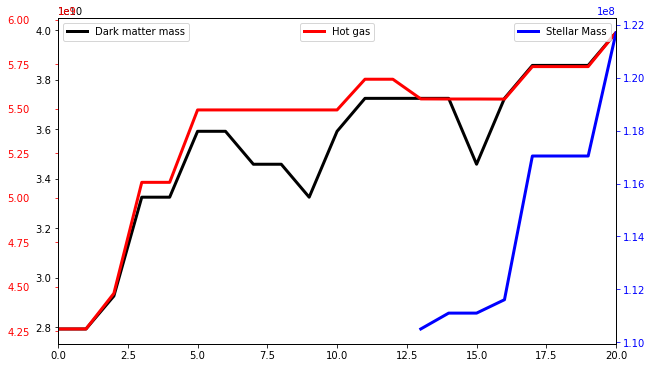

In [10]:
hot_gass = []
dm_mass = []
stellar_mass = [] 
prog_mass = []
for i in range(0,23):
    hot_gass.append(array_of_halo_properties[i].hot_gas_mass)
    dm_mass.append(array_of_halo_properties[i].mass)
    prog_mass.append(array_of_halo_properties[i].mass_from_progenitors)
    stellar_mass.append(array_of_halo_properties[i].sub_halo_attrs['stellar_mass'])
    

fig, ax1 = plt.subplots(figsize = (10, 6))
    
ax1.plot(dm_mass,color = 'black', lw = 3,label='Dark matter mass')
ax2 = ax1.twinx()

    
ax2.plot(hot_gass, color = 'red', lw = 3,label = 'Hot gas')

ax3 = ax2.twinx()
stellar_mass = [i for i in stellar_mass if len(i) == 1]

ax3.plot(np.arange(0,len(stellar_mass),1) + 13,stellar_mass, label ='Stellar Mass',lw =3,color='blue')
plt.xlim(0,20)
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='black')
ax2.tick_params(axis='y', colors='red',pad=25)
ax3.tick_params(axis='y', colors='blue')
offset = ax2.yaxis.get_major_formatter().get_offset()
# ax2.yaxis.offsetText.set_visible(False)

# ax2.set_ylabel(offset)
plt.show()

In [7]:
# Plot hot gas, hotgas + stellar mass. 